In [74]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from src.data import make_dataset
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv

In [78]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [80]:
competition = os.environ['COMPETITION']

# Set up directories

In [65]:
project_dir = Path.cwd().parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [57]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')
df_test = pd.read_csv(raw_data_dir / 'test.csv')
X_train = np.load(interim_data_dir / 'X_train.npy')
X_val = np.load(interim_data_dir / 'X_val.npy')
y_train = np.load(interim_data_dir / 'y_train.npy')
y_val = np.load(interim_data_dir / 'y_val.npy')
X_test = np.load(interim_data_dir / 'X_test.npy')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

The base line prediction is simply to make them all negative.

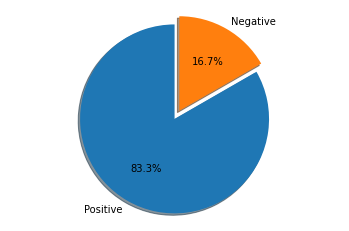

In [36]:
labels = 'Positive', 'Negative'
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

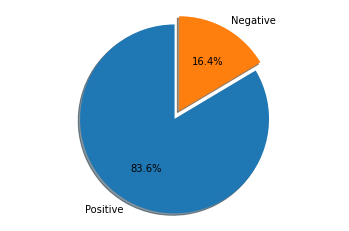

In [37]:
labels = 'Positive', 'Negative'
pos_count = (y_val == 1).sum()
neg_count = (y_val == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [38]:
preds = [1] * len(y_val)
roc_auc_score(y_val, preds)

0.5

# XGB

In [39]:
clf_xgb = xgb.XGBClassifier()

In [40]:
clf_xgb.fit(X_train, y_train)

c:\users\mactuary\.virtualenvs\assignment_1-9rwzg4k3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
preds = clf_xgb.predict(X_val)
probs = clf_xgb.predict_proba(X_val)

In [42]:
X_val.shape

(1600, 19)

In [43]:
len(y_val)

1600

In [44]:
auc = roc_auc_score(y_val, probs[:, 1])
tpr, fpr, threshold = roc_curve(y_val, probs[:, 1])
auc

0.6601664813398136

# RandomizedSearchCV

In [45]:
# test
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-null   float64
 19  BLK   

In [46]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss'
        ))
])

param_dist = {
    'pca__n_components': stats.randint(1, X_train.shape[1]),
    'classifier__n_estimators': stats.randint(150, 1000),
    'classifier__learning_rate': stats.uniform(0.01, 0.6),
    'classifier__subsample': stats.uniform(0.3, 0.9),
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__colsample_bytree': stats.uniform(0.5, 0.9),
    'classifier__min_child_weight': [1, 2, 3, 4]
}

cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    random_state=42,
    n_iter=100,
    cv=5,
    n_jobs=7,
    verbose=10
)

cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\users\mactuary\.virtualenvs\assignment_1-9rwzg4k3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.79984375        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.80375
 0.79109375 0.83296875        nan        nan        nan        nan
        nan 0.80578125 0.8015625         nan 0.7915625  0.79265625
 0.81578125 0.81984375        nan        nan 0.81       0.80484375
 0.7975     0.7978125  0.8175            nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.79671875        nan        nan        nan        nan        nan
        nan        nan 0.79296875        nan 0.79421875        nan
        nan 0.793125          nan 0.8009375         nan 0.82890625
        nan        nan        nan        nan 0.78171875 0.8346875
 0.79125           nan 0.8025            nan        nan 0.80671875
        nan 0.82859375       

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='logloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            intera

In [60]:
dump(cv, models_dir / 'randomised_xgb')

['D:\\OneDrive - UTS\\mdsi\\36114 Advanced Data Science for Innovation\\assignment_1\\models\\randomised_xgb']

In [47]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__subsample,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.384030,0.165592,0.0238,0.006766,0.837086,0.580429,5,4,850,0.837165,11,{'classifier__colsample_bytree': 0.83708610696...,0.790625,0.805469,0.807813,0.794531,0.800781,0.799844,0.006469,22
1,0.423614,0.455701,0.0000,0.000000,0.913324,0.210225,5,2,458,1.172919,12,{'classifier__colsample_bytree': 0.91332400276...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
2,0.046200,0.001327,0.0000,0.000000,1.344697,0.010467,6,1,310,0.573818,12,{'classifier__colsample_bytree': 1.34469743811...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77
3,0.051800,0.007332,0.0000,0.000000,0.520756,0.324865,9,2,625,1.17638,15,{'classifier__colsample_bytree': 0.52075618253...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
4,0.040599,0.008523,0.0000,0.000000,0.910463,0.481106,5,4,716,1.184908,3,{'classifier__colsample_bytree': 0.91046298579...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.035000,0.001788,0.0000,0.000000,1.153509,0.464249,5,1,234,0.70549,14,{'classifier__colsample_bytree': 1.15350875966...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
96,6.253240,1.374882,0.0126,0.001744,0.726298,0.174839,6,2,598,0.904531,2,{'classifier__colsample_bytree': 0.72629819556...,0.800000,0.797656,0.802344,0.803906,0.808594,0.802500,0.003711,18
97,9.329741,0.423306,0.0082,0.000749,0.822346,0.078135,4,2,823,0.72859,3,{'classifier__colsample_bytree': 0.82234644622...,0.822656,0.821094,0.818750,0.820312,0.821094,0.820781,0.001269,7
98,7.459398,1.045633,0.0090,0.002450,0.968147,0.521309,8,4,538,0.379567,17,{'classifier__colsample_bytree': 0.96814715100...,0.766406,0.772656,0.779687,0.782031,0.782813,0.776719,0.006277,37


## Predictions with the best model

In [48]:
preds = cv.predict(X_val)
probs = cv.predict_proba(X_val)

In [49]:
len(probs[:, 1])

1600

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, probs[:, 1])
roc_auc_score(y_val, probs[:, 1])

0.7007032940781672

In [51]:
confusion_matrix(y_val, preds)

array([[   3,  260],
       [   2, 1335]], dtype=int64)

## Predict on test set

In [68]:
preds = cv.predict(X_test)

## Save predictions

In [81]:
pred_name = 'TARGET_5Yrs'
pred_path = processed_data_dir / 'preds_randomised_xgb.csv'
make_dataset.save_predictions(preds, pred_name, test_id, pred_path)

In [83]:
pred_path.stem

'preds_randomised_xgb'

## Submit predictions

In [85]:
api.competition_submit(file_name=pred_path,
                       message=pred_path.stem,
                       competition=competition,
                       quiet=False)

100%|██████████████████████████████████████████████████████████████████████████| 28.6k/28.6k [00:07<00:00, 3.68kB/s]


Successfully submitted to [UTS AdvDSI] NBA Career Prediction

## Predictions 2nd best model

There's a very small difference in the `mean_test_score`s of the first and second. The second ranked model uses only 2 `pca_n_components`. The best model on the training set might be overfitting due to the large number of components. Let's try the second best model on the validation set.

In [53]:
type(cv)

sklearn.model_selection._search.RandomizedSearchCV

In [61]:
def get_parameters(cv: RandomizedSearchCV,
                   step: str,
                   nth: int) -> Dict[str, float]:
    """
    Extract the parameters of the non-first ranked model from a RandomizedSearchCV object,
    so that they may be used to fit another model.
    """
    key_list = [key for key in cv.cv_results_.keys() if step in key]
    return key_list